# Visualizing the Embedding space with PCA and BERT

In this notebook, we will use our embedded fasta files to generate PCA visualizations of the embedding space for subcellular location.

In [1]:
from Bio import SeqIO
import pandas as pd
import torch
from tape import ProteinBertModel, TAPETokenizer
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import numpy as np
import pandas as pd
import json

from sklearn.linear_model import LogisticRegression
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

First, we will load our npz files using numpy as well as the label files generated in `generate_deeploc_data.ipynb`. Next, we will iterate through the train, valid, and test arrays to generate a dataframe with the embedded features for each sequence

In [2]:
def gen_df(embeddings):
    """
    Iterate over all of the sequence IDs in the given subset of the dataset (embeddings),
    as a nested numpy array. Produce a numpy array of the average embeddings for each
    sequence, as will a list of the labels by looking up the sequence IDs in seq_id_to_label
    
    Args:
        embeddings (numpy.lib.npyio.NpzFile): Nested numpy array containing embeddings for each sequence ID
        seq_id_to_label (dict[str,str]): Map from sequence ID to classification label
    
    Returns:
        output (pd.DataFrame): Average embeddings for each sequence
        labels (list[str])
    """
    keys = embeddings.files
    output, labels = [], []
    for key in keys:
        d = embeddings[key].item()["avg"]
        labels.append(seq_id_to_label[key])
        output.append(d)
    return pd.DataFrame(output), labels

In [3]:
id_dict = {
    'Cell.membrane': 0, 
    'Cytoplasm': 1, 
    'Endoplasmic.reticulum': 2, 
    'Golgi.apparatus': 3, 
    'Lysosome/Vacuole': 4,
    'Mitochondrion': 5, 
    'Nucleus': 6,
    'Peroxisome': 7, 
    'Plastid': 8,
    'Extracellular': 9
}

In [4]:
seq_id_to_label = {}
seq_list = []

# generate lookup dictionary for labels from original fasta file
for record in SeqIO.parse("../data/deeploc_data_6000.fasta", "fasta"):
    description = record.description
    seq = record.seq
    seq_list.append(len(str(seq)))
    desc_split = description.split(" ")
    ID = desc_split[0]
    label = desc_split[1]
    label = label[:len(label)-2]
    seq_id_to_label[ID] = label

# load data from npz files
train_arrays = np.load('../data/output_deeploc_train_6000.npz', allow_pickle=True)
valid_arrays = np.load('../data/output_deeploc_valid_6000.npz', allow_pickle=True)
test_arrays = np.load('../data/output_deeploc_test_6000.npz', allow_pickle=True)

train_df, train_labels = gen_df(train_arrays)
valid_df, valid_labels = gen_df(valid_arrays)
test_df, test_labels = gen_df(test_arrays)

In [5]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(9974, 768)
(1109, 768)
(2773, 768)


In [6]:
deeploc_df = train_df.append(valid_df, ignore_index=True).append(test_df, ignore_index=True)
labels = train_labels + valid_labels + test_labels

Using PCA, we can reduce the overall dimensionality of our data to visualize it in two or 3 dimensions.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(deeploc_df)
print(sum(pca.explained_variance_ratio_))

0.2792523467726383


In [8]:
explained_variance = []
n_components = [1, 2, 3, 5, 10, 50, 100, 250, 500, 750]
for n in n_components:
    pca_t = PCA(n_components=n)
    principalComponents_t = pca_t.fit_transform(deeploc_df)
    explained_variance.append(sum(pca_t.explained_variance_ratio_))

In [9]:
import matplotlib.pyplot as plt
plt.plot(n_components, explained_variance )
plt.ylabel('Explained Variance')
plt.xlabel('Number of PCA components')
plt.show()

<Figure size 640x480 with 1 Axes>

We see that the variance explained in 3 dimensions is only around 28 percent, whereas greater than 100 components explains around 95% of the data. For visualization purposes, we can see how our data looks in 2 and 3 dimensions.

In [14]:
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])
principal_df['label'] = labels

In [16]:
principal_df.head()

pc1       pc2       pc3             label
0  0.344463 -5.197507 -1.836191         Cytoplasm
1 -3.438836 -1.497950  1.315390         Cytoplasm
2 -3.218042  1.217870 -1.819425  Lysosome/Vacuole
3  3.365510  1.201206  5.758324           Nucleus
4 -1.195363 -1.479472 -1.529109           Nucleus

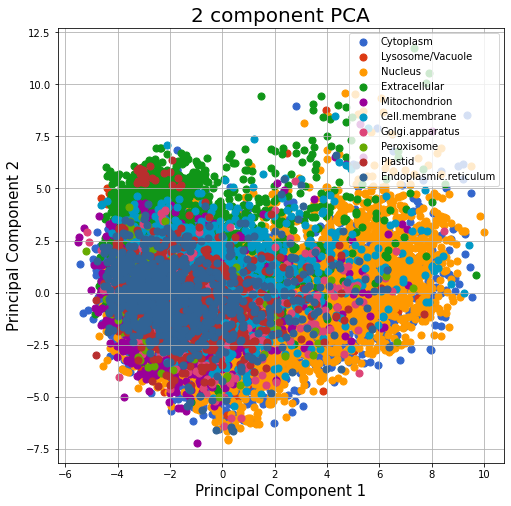

In [11]:
import matplotlib.pyplot as plt
import plotly.express as px
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list(principal_df['label'].unique())
colors =px.colors.qualitative.G10
for target, color in zip(targets,colors):
    indicesToKeep = principal_df['label'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'pc1']
               , principal_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

In [12]:
import plotly.express as px
plt.figure(figsize=(25, 25))
fig = px.scatter(principal_df, x='pc1', y='pc2',
              color='label', color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

<Figure size 1800x1800 with 0 Axes>

In [13]:
import plotly.express as px
fig = px.scatter_3d(principal_df, x='pc1', y='pc2', z='pc3',
              color='label', color_discrete_sequence=px.colors.qualitative.G10)
fig.show()